# K-Means clustering

## Add the required libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
pip install validclust

In [3]:
import random
from sklearn.metrics import silhouette_score
from validclust import cop
from sklearn.metrics import pairwise_distances
from validclust import dunn
import cv2
np.random.seed(30)


##Load the CIFAR-10 Dataset

In [38]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [39]:
x_test.shape

(10000, 32, 32, 3)

## Convert the test RGB images to Greyscale

In [40]:
x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])

In [41]:
x_train[0].shape

(32, 32)

## Normalize the images

In [42]:
x_train = x_train.astype('float32') / 255

## Convert the images to 1D vector

In [43]:
x_train = x_train.reshape((-1, 1024))

In [44]:
x_train.shape

(10000, 1024)

## Function calc_new_cen() takes current centroid and x_train as input
* For every cluster the mean is calculated and the new centroids are returned

In [45]:
def calc_new_cen(current_cen,x):

  new_cen = []
  clus_list = np.unique(current_cen)
  for i in clus_list:
    l = x[i == current_cen].mean(axis = 0)
    new_cen.append(l)

  return np.array(new_cen)


### Function assign group is used to assign the points to different clusters


In [46]:
#Here for each point,euclidean distance is calculated from centroids
#A point is assigned to a group of cluster if its euclidean distance from that centroid is shortest compared to other centroids
#After assigning the group,the groups are returned

def assign_group(x,centroids):
  group = []
  for i in x:
    single_ele = []
    for j in centroids:
      sd = np.dot((i-j),(i-j))
      euc_dis = np.sqrt(sd)
      single_ele.append(euc_dis)
    min_dis = min(single_ele)
    pos = single_ele.index(min_dis)
    group.append(pos)

  return np.array(group)

### Function fit_kmeans is used to fit the data into kmeans model

*   It chooses 10 random points as the cluster centroid.
*   Number of iteration = 200 is taken 
*   For every iteration the points are grouped into clusters 
*   Then centroids are calculated by finding the mean
*   This steps are repeated till it converges 




In [47]:
def fit_kmeans(x,max_iter,n_clusters):


  centroids = x[np.random.choice(x.shape[0], n_clusters, replace=False), :]
  iteration_no = 0
  for i in range(max_iter):
    if i%10 == 0 :
      print(i)
    current_group = assign_group(x,centroids)
    previous_centroids = centroids
    new_cen = calc_new_cen(current_group,x)
    if (previous_centroids == new_cen).all():
      iteration_no = i + 1
      break
    centroids = new_cen
  if iteration_no == 0:
      print("Number of iterations taken to converge :",200)
  else:
    print("Number of iterations taken to converge :",iteration_no)
  
  return current_group



In [48]:
n_clusters = 10
max_iter = 200

pred = fit_kmeans(x_train,max_iter,n_clusters)

0
10
20
30
40
50
Number of iterations taken to converge : 56


In [49]:
print(f'Silhouette Score for the cifar-10 test dataset(n=10): {silhouette_score(x_train, pred)}')


Silhouette Score for the cifar-10 test dataset(n=10): 0.05434064939618111


In [50]:
dist = pairwise_distances(x_train)

In [51]:
print("Dunn's Index is:",dunn(dist, pred))

Dunn's Index is: 0.089936316


# Autoencoder


### Add required libraries for autoencoder

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow import keras


### Get cifar dataset and normalize the dataset

In [19]:
def get_cifar():
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255

  return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = get_cifar()
x_test.shape

(10000, 32, 32, 3)

### Initially image is of shape 32 x 32 x 3

In [20]:
  input = layers.Input(shape=(32, 32, 3))



## Encoder


*   2 convolutional layers are added.
*   Downsampling is done using the function MaxPooling2D
*   Final shape of encoded image is 8x8x3



In [21]:
def encoder_init():

  x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
  x = layers.MaxPooling2D((2, 2), padding="same")(x)
  x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)
  x = layers.MaxPooling2D((2, 2), padding="same")(x)
  return x


## Decoder


*   2 deconvolutional layers are used to reconstruct the image from encoded data.
*   For getting the final output,output from deconvolution layer is passed to a convolutional layer with sigmoid activation function. 
*   Final shape of decoded image is 32x32x3



In [22]:
def decoder_init(encoder_input):
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
  return x

### Autoencoder

* Using the encoder and decoder,an autoencoder model is created.
* The model is compiled using adam as optimizer and mean sqaure error as loss function


In [23]:
encoder_op = encoder_init()
encoder = Model(input,encoder_op, name='encoder')
# encoder.summary()

decoder_op = decoder_init(encoder_op)
decoder = Model(encoder_op,decoder_op,name="decoder")
# decoder.summary()
autoencoder = Model(input, decoder(encoder(input)),name="autoencoder")
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 8, 8, 3)           1763      
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         11011     
                                                                 
Total params: 12,774
Trainable params: 12,774
Non-trainable params: 0
_________________________________________________________________


### Training
* The model is trained on cifar-10 training data
* The number of epoch is 5 and batch size is 128

In [24]:
autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=5,
    batch_size=128,
    validation_data=(x_test, x_test),
)

Epoch 1/5
391/391 [==============================] - 39s 25ms/step - loss: 0.0202 - val_loss: 0.0104
Epoch 2/5
391/391 [==============================] - 9s 23ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 3/5
391/391 [==============================] - 9s 23ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 4/5
391/391 [==============================] - 9s 23ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/5
391/391 [==============================] - 9s 23ms/step - loss: 0.0075 - val_loss: 0.0073


### The trained model is used to reconstruct training dataset 

In [25]:
predictions = autoencoder.predict(x_train)


In [26]:
testpredictions = autoencoder.predict(x_test)

### Reconstructed sample image from train dataset 

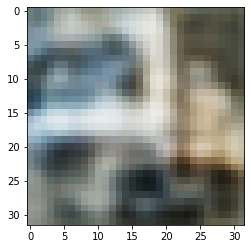

In [27]:
plt.imshow(predictions[1].reshape(32,32,3))

### Orginal sample image from train dataset

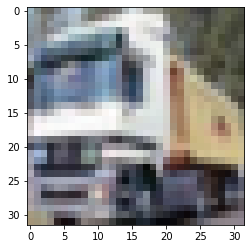

In [28]:
plt.imshow(x_train[1])

### Encoder model is used to create encoded data of test dataset

In [29]:
eo = encoder.predict(x_test)

### Orginal sample image from test dataset

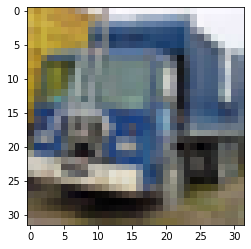

In [30]:
plt.imshow(x_test[14])

### Reconstructed sample image from test dataset

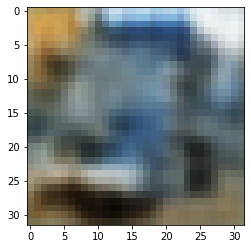

In [31]:
plt.imshow(testpredictions[14])

### Encoded sample image from test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


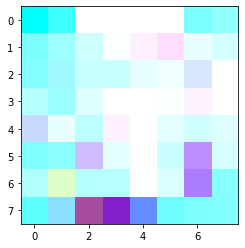

In [32]:
plt.imshow(eo[14].reshape(8,8,3))

### K-Means clustering is done on encoded data of cifar-10 dataset

* maximum iterations = 200
* number of clusters = 10

In [33]:
n_clusters = 10
max_iter = 200
eo = eo.reshape((-1, 192))
print(eo.shape)
eo_pred = fit_kmeans(eo,max_iter,n_clusters)

(10000, 192)
0
10
20
30
40
Number of iterations taken to converge : 43


In [34]:
l = x_test.reshape(-1,32*32*3)
l.shape

(10000, 3072)

###  Silhouette Score for the cifar-10 encoded test dataset

In [35]:
print(f'Silhouette Score for the cifar-10 encoded test dataset(n=10): {silhouette_score(l, eo_pred)}')


Silhouette Score for the cifar-10 encoded test dataset(n=10): 0.05269095301628113


### Dun score

In [36]:

dist = pairwise_distances(l)
print("Dunn's Index for the cifar-10 encoded test dataset is:",dunn(dist, eo_pred))

Dunn's Index for the cifar-10 encoded test dataset is: 0.11497647
